In [1]:
# check gpu status
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12823338315443674319
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 4823745686240553957
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2023-12-16 16:01:05.860492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-16 16:01:05.860509: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-16 16:01:05.860514: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-16 16:01:05.860742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 16:01:05.861099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading the data

In [14]:
# Import modules
from __future__ import print_function
import numpy as np
import pickle
from tqdm import tqdm
import cv2
import os
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW,SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/train"

x_train = []
y_train = []
for class_idx, classes in enumerate(os.listdir(train_dir)):
    if classes.endswith(".DS_Store"):
        continue
    print(f"Processing class {class_idx + 1}/{len(os.listdir(train_dir))}: {classes}")
    
    # Iterate over images
    for image_idx, images in enumerate(os.listdir(os.path.join(train_dir, classes, "images"))):
        image = cv2.imread(os.path.join(train_dir, classes, "images", images))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(img) / 255.0
        x_train.append(img_array)
        y_train.append(classes)

print("Dataset loading completed.")

Processing class 1/200: n01443537
Processing class 2/200: n01629819
Processing class 3/200: n01641577
Processing class 4/200: n01644900
Processing class 5/200: n01698640
Processing class 6/200: n01742172
Processing class 7/200: n01768244
Processing class 8/200: n01770393
Processing class 9/200: n01774384
Processing class 10/200: n01774750
Processing class 11/200: n01784675
Processing class 12/200: n01855672
Processing class 13/200: n01882714
Processing class 14/200: n01910747
Processing class 15/200: n01917289
Processing class 16/200: n01944390
Processing class 17/200: n01945685
Processing class 18/200: n01950731
Processing class 19/200: n01983481
Processing class 20/200: n01984695
Processing class 21/200: n02002724
Processing class 22/200: n02056570
Processing class 23/200: n02058221
Processing class 24/200: n02074367
Processing class 25/200: n02085620
Processing class 26/200: n02094433
Processing class 27/200: n02099601
Processing class 28/200: n02099712
Processing class 29/200: n021

In [8]:
my_dict = {}
f = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt"
with open(f, 'r', newline='', encoding='utf-8') as tsvfile:
    # Create a CSV reader with tab as the delimiter
    reader = csv.reader(tsvfile, delimiter='\t')
    # Iterate through the rows in the TSV file
    for row in reader:
        # Each row is a list of values corresponding to columns
        my_dict[row[0]] = row[1]

val_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/images"

x_val = []
y_val =[]

for images in os.listdir(val_dir):
    image = cv2.imread(os.path.join(val_dir,images))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(img) / 255.0
    x_val.append(img_array)
    y_val.append(my_dict[images])  

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [13]:
# Save the training data with pickle for faster loading

save_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(save_dir, 'x_train.pkl'), 'wb') as file:
    pickle.dump(x_train, file)

with open(os.path.join(save_dir, 'y_train.pkl'), 'wb') as file:
    pickle.dump(y_train, file)

with open(os.path.join(save_dir, 'x_val.pkl'), 'wb') as file:
    pickle.dump(x_val, file)

with open(os.path.join(save_dir, 'y_val.pkl'), 'wb') as file:
    pickle.dump(y_val, file)

In [3]:
# loading data with pickle

load_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(load_dir, 'x_train.pkl'), 'rb') as file:
    x_train = pickle.load(file)

with open(os.path.join(load_dir, 'y_train.pkl'), 'rb') as file:
    y_train = pickle.load(file)

with open(os.path.join(load_dir, 'x_val.pkl'), 'rb') as file:
    x_val = pickle.load(file)

with open(os.path.join(load_dir, 'y_val.pkl'), 'rb') as file:
    y_val = pickle.load(file)

In [45]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_val.shape)
print('Test labels shape: ', y_val.shape)

Training data shape:  (100000, 64, 64, 3)
Training labels shape:  (100000,)
Test data shape:  (10000, 64, 64, 3)
Test labels shape:  (10000,)


In [11]:
# Training conditions
intializer = GlorotNormal(seed=None)
def scheduler(epoch, lr):
    if epoch != 30 or epoch != 30 or epoch != 90:
        return lr
    else:
        return lr/10
    
callback = LearningRateScheduler(scheduler)
datagen = ImageDataGenerator(horizontal_flip=True)

## 1: Batch Normalization

In [15]:
# Mimicing of the original ResNet model, training with this leads to severe overfitting, thus not used

compiled_model = Sequential()

compiled_model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

compiled_model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=intializer))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(1024, (1, 1), strides=(1, 1), kernel_initializer=intializer))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))

compiled_model.add(Conv2D(512, (1, 1), strides=(2, 2), kernel_initializer=intializer))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=intializer))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(2048, (1, 1), strides=(1, 1), kernel_initializer=intializer))
compiled_model.add(BatchNormalization(gamma_initializer="zeros"))
compiled_model.add(Activation('relu'))

compiled_model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

compiled_model.add(Dense(128, kernel_initializer='he_normal'))
compiled_model.add(Activation('relu'))

compiled_model.add(Dropout(0.5))

# Output layer
num_classes = 200
compiled_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(compiled_model.summary())
compiled_model.compile(optimizer=SGD(weight_decay=0.0001,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 batch_normalization_21 (Ba  (None, 29, 29, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 batch_normalization_22 (Ba  (None, 15, 15, 256)      

None


In [10]:
# Simpliyied ResNet model that works better with the Tiny_ImageNet-200 dataset, using this model

model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(BatchNormalization(gamma_initializer="zeros"))
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=SGD(weight_decay=0.0001,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 15, 256)      1

In [11]:
batch_size = 64
epochs = 100

hist1 = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          epochs=epochs,
          verbose=1,
          validation_data=datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          callbacks = [callback])

Epoch 1/100
1563/1563 [==============================] - 16s 5ms/step - loss: 4.8607 - accuracy: 0.0393 - val_loss: 4.4531 - val_accuracy: 0.0893
Epoch 2/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.4543 - accuracy: 0.0766 - val_loss: 4.3485 - val_accuracy: 0.0887
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 4.3259 - accuracy: 0.0932 - val_loss: 4.1597 - val_accuracy: 0.1161
Epoch 4/100
1563/1563 [==============================] - 6s 4ms/step - loss: 4.2432 - accuracy: 0.1018 - val_loss: 4.3590 - val_accuracy: 0.0923
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 4.1901 - accuracy: 0.1079 - val_loss: 4.1358 - val_accuracy: 0.1134
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 4.1411 - accuracy: 0.1147 - val_loss: 4.0916 - val_accuracy: 0.1180
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 4.1092 - accuracy: 0.1188 - val_loss: 3.9610 - val_a

In [14]:
# Save hist1

with open('hist1.pkl', 'wb') as file:
    pickle.dump(hist1.history, file)

In [15]:
# Load hist1

with open(os.path.join(load_dir, 'hist1.pkl'), 'rb') as file:
    hist1 = pickle.load(file)

## 2: Group Normalization

In [8]:
from GroupNormalization import GroupNormalization

In [9]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(GroupNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(GroupNormalization(gamma_initializer="zeros"))
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=SGD(weight_decay=0.0001,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        9472      
                                                                 
 group_normalization (GroupN  (None, 29, 29, 64)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 group_normalization_1 (Grou  (None, 15, 15, 256)      5

In [10]:
batch_size = 64
epochs = 100

hist2 = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          epochs=epochs,
          verbose=1,
          validation_data=datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          callbacks = [callback])

Epoch 1/100
1563/1563 [==============================] - 42s 9ms/step - loss: 5.1375 - accuracy: 0.0163 - val_loss: 4.8941 - val_accuracy: 0.0373
Epoch 2/100
1563/1563 [==============================] - 12s 8ms/step - loss: 4.8350 - accuracy: 0.0369 - val_loss: 4.5579 - val_accuracy: 0.0637
Epoch 3/100
1563/1563 [==============================] - 12s 8ms/step - loss: 4.6369 - accuracy: 0.0538 - val_loss: 4.3405 - val_accuracy: 0.0987
Epoch 4/100
1563/1563 [==============================] - 12s 8ms/step - loss: 4.5096 - accuracy: 0.0658 - val_loss: 4.2446 - val_accuracy: 0.1068
Epoch 5/100
1563/1563 [==============================] - 12s 8ms/step - loss: 4.4196 - accuracy: 0.0754 - val_loss: 4.1686 - val_accuracy: 0.1199
Epoch 6/100
1563/1563 [==============================] - 11s 7ms/step - loss: 4.3539 - accuracy: 0.0825 - val_loss: 4.0962 - val_accuracy: 0.1300
Epoch 7/100
1563/1563 [==============================] - 11s 7ms/step - loss: 4.2984 - accuracy: 0.0908 - val_loss: 4.0043 -

In [ ]:
# Save hist2

with open('hist2.pkl', 'wb') as file:
    pickle.dump(hist2.history, file)

In [18]:
# Load hist2

with open(os.path.join(load_dir, 'hist2.pkl'), 'rb') as file:
    hist2 = pickle.load(file)

## 3: Instance Normalization

In [6]:
from InstanceNormalization import InstanceNormalization

In [7]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(InstanceNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(InstanceNormalization(gamma_initializer="zeros"))
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=SGD(weight_decay=0.0001,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        9472      
                                                                 
 instance_normalization (Ins  (None, 29, 29, 64)       2         
 tanceNormalization)                                             
                                                                 
 activation (Activation)     (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 instance_normalization_1 (I  (None, 15, 15, 256)      2

In [8]:
batch_size = 64
epochs = 100

hist3 = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          epochs=epochs,
          verbose=1,
          validation_data=datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          callbacks = [callback])

Epoch 1/100
1563/1563 [==============================] - 11s 5ms/step - loss: 5.1062 - accuracy: 0.0189 - val_loss: 4.8220 - val_accuracy: 0.0478
Epoch 2/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.7348 - accuracy: 0.0473 - val_loss: 4.5073 - val_accuracy: 0.0730
Epoch 3/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.5503 - accuracy: 0.0653 - val_loss: 4.2884 - val_accuracy: 0.1058
Epoch 4/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.4530 - accuracy: 0.0768 - val_loss: 4.2114 - val_accuracy: 0.1162
Epoch 5/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.3856 - accuracy: 0.0841 - val_loss: 4.1564 - val_accuracy: 0.1238
Epoch 6/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.3427 - accuracy: 0.0882 - val_loss: 4.0766 - val_accuracy: 0.1329
Epoch 7/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.2937 - accuracy: 0.0952 - val_loss: 4.0304 - val_a

In [9]:
# Save hist3

with open('hist3.pkl', 'wb') as file:
    pickle.dump(hist3.history, file)

In [ ]:
# Load hist3

with open(os.path.join(load_dir, 'hist3.pkl'), 'rb') as file:
    hist3 = pickle.load(file)

## 4. Layer Normalization

In [10]:
from keras.layers import LayerNormalization

In [11]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(LayerNormalization(axis=[1,2,3]))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(LayerNormalization(axis=[1,2,3],gamma_initializer="zeros"))
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=SGD(weight_decay=0.0001,momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        9472      
                                                                 
 layer_normalization (LayerN  (None, 29, 29, 64)       107648    
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 layer_normalization_1 (Laye  (None, 15, 15, 256)     

In [12]:
batch_size = 64
epochs = 100

hist4 = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          epochs=epochs,
          verbose=1,
          validation_data=datagen.flow(x_train,y_train,batch_size=batch_size,subset="Training"),
          callbacks = [callback])

Epoch 1/100
1563/1563 [==============================] - 9s 6ms/step - loss: 5.1071 - accuracy: 0.0184 - val_loss: 4.8195 - val_accuracy: 0.0424
Epoch 2/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.7844 - accuracy: 0.0413 - val_loss: 4.4792 - val_accuracy: 0.0761
Epoch 3/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.5902 - accuracy: 0.0587 - val_loss: 4.3333 - val_accuracy: 0.1018
Epoch 4/100
1563/1563 [==============================] - 7s 5ms/step - loss: 4.4780 - accuracy: 0.0706 - val_loss: 4.1972 - val_accuracy: 0.1175
Epoch 5/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.3943 - accuracy: 0.0800 - val_loss: 4.1235 - val_accuracy: 0.1258
Epoch 6/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.3317 - accuracy: 0.0865 - val_loss: 4.0610 - val_accuracy: 0.1319
Epoch 7/100
1563/1563 [==============================] - 7s 4ms/step - loss: 4.2764 - accuracy: 0.0936 - val_loss: 4.0233 - val_ac

In [17]:
# Save hist4

with open('hist4.pkl', 'wb') as file:
    pickle.dump(hist4.history, file)

In [ ]:
# Load hist4

with open(os.path.join(load_dir, 'hist4.pkl'), 'rb') as file:
    hist4 = pickle.load(file)

## Visualization of Results from BatchNorm, GroupNorm and InstanceNorm

In [21]:
def plot_history(hists, attribute='val_loss', axis=(-1,14,0.7,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acy': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_accuracy': 'valid. accuracy', 'accuracy': 'trn._ accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(8, 5))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['BatchNorm', 'GroupNorm', 'InstNorm','LayerNorm'], loc=loc)  

    plt.show()

In [36]:
def load_history(file_path):
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
    return history

def plot_history(files, attribute='accuracy', axis=None, loc=None):
    plt.figure(figsize=(10, 6))
    plt.axis(axis)
    
    for file in files:
        history = load_history(file)
        plt.plot(history[attribute], label=file)

    plt.title(f'Training History - {attribute}')
    plt.xlabel('Epoch')
    plt.ylabel(attribute)
    plt.legend(['BatchNorm', 'GroupNorm', 'InstNorm','LayerNorm'], loc=loc)
    plt.show()

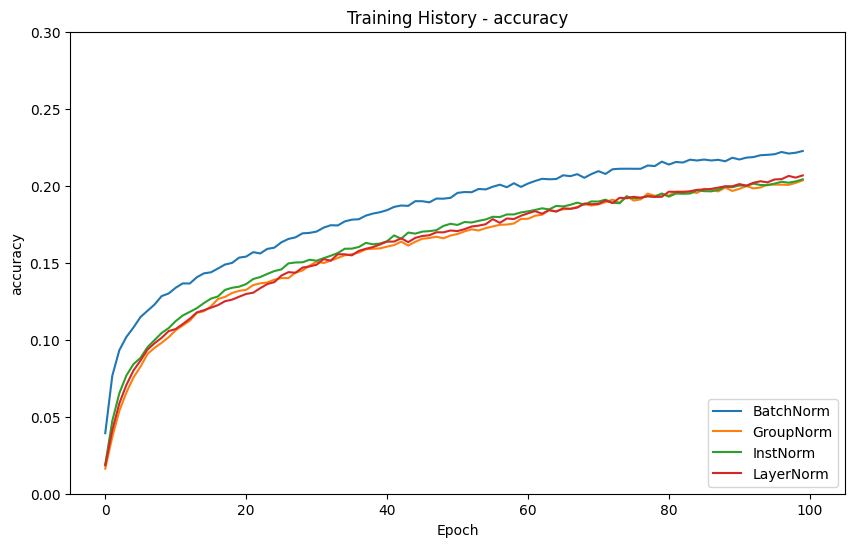

In [40]:
history_files = ['hist1.pkl', 'hist2.pkl', 'hist3.pkl', 'hist4.pkl']
plot_history(history_files, attribute='accuracy', axis=(-5, 105, 0, 0.3), loc='lower right')

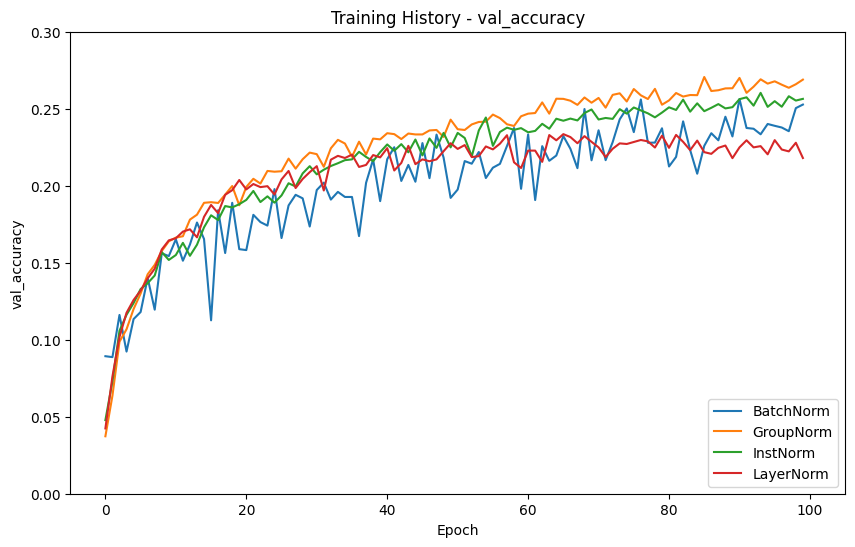

In [38]:
plot_history(history_files, attribute='val_accuracy', axis=(-5, 105, 0, 0.3), loc='lower right')

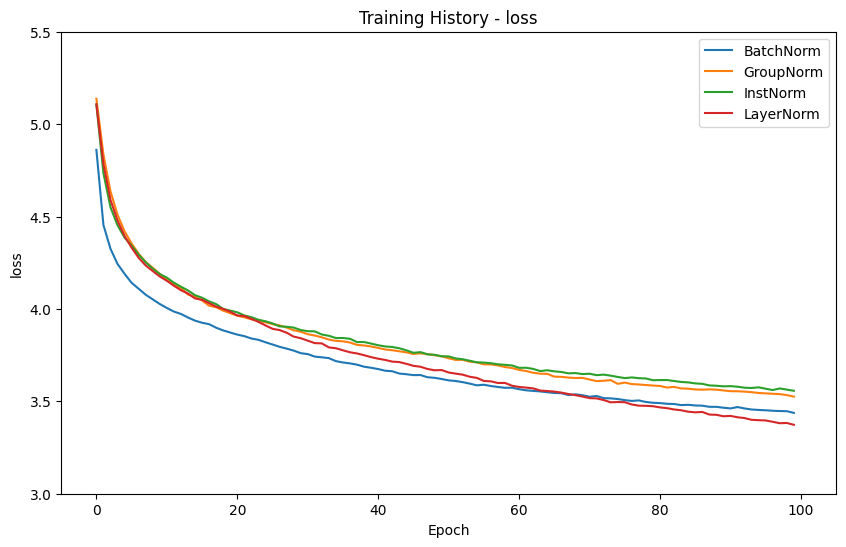

In [43]:
plot_history(history_files, attribute='loss', axis=(-5, 105, 3, 5.5), loc='upper right')

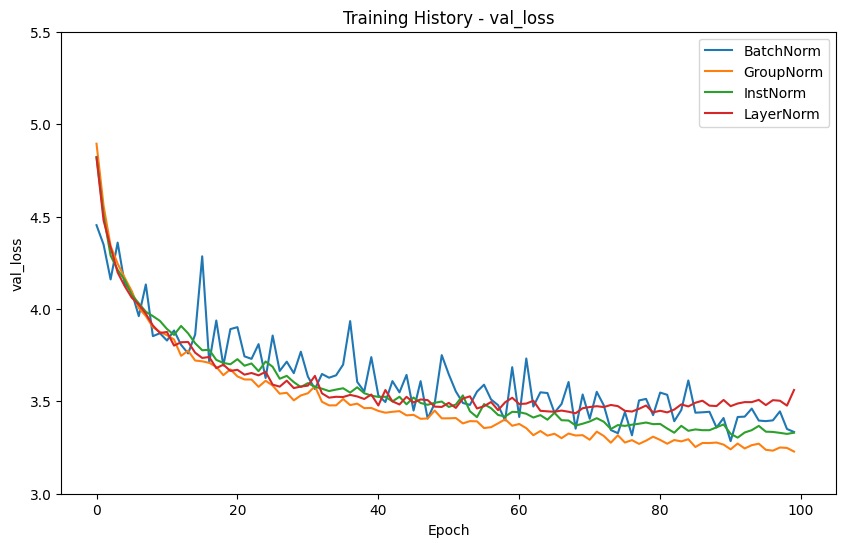

In [44]:
plot_history(history_files, attribute='val_loss', axis=(-5, 105, 3, 5.5), loc='upper right')

In [ ]:
import numpy as np
print(np.median(hist1.history['val_loss'][-5:]))
print(np.median(hist2.history['val_loss'][-5:]))
print(np.median(hist3.history['val_loss'][-5:]))
print(np.median(hist4.history['val_loss'][-5:]))